In [1]:
# Standard library imports
import sys
import os
import requests
import itertools
import math
from io import StringIO
from tqdm import tqdm
from typing import Tuple

# 3rd-party library imports
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Step 0

In [2]:
'''
Step 0: Downloading Data

Combining diverse inputs into a single dataset

Inputs include:
    - GHCN v4 data
    - ERRST v5 data (later on?)
'''

# Standard library imports
import requests
import sys
import os
from typing import List

# 3rd-party library imports
import pandas as pd
import numpy as np

# Add the parent folder to sys.path
# parent_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
# sys.path.insert(0, parent_dir)

# Local imports
# from parameters.data import GHCN_temp_url, GHCN_meta_url
GHCN_temp_url = 'https://data.giss.nasa.gov/pub/gistemp/ghcnm.tavg.qcf.dat'
GHCN_meta_url = 'https://data.giss.nasa.gov/pub/gistemp/v4.inv'
start_year = 1880

# Local imports
from parameters.data import GHCN_temp_url, GHCN_meta_url

def get_GHCN_data(temp_url: str, meta_url: str, start_year: int) -> pd.DataFrame:
    '''
    Retrieves and formats temperature data from the Global Historical Climatology Network (GHCN) dataset.

    Args:
    temp_url (str): The URL to the temperature data file in GHCN format.
    meta_url (str): The URL to the metadata file containing station information.

    Returns:
    pd.DataFrame: A Pandas DataFrame containing temperature data with station metadata.
    
    This function sends an HTTP GET request to the temperature data URL, processes the data to create
    a formatted DataFrame, replaces missing values with NaN, converts temperature values to degrees Celsius,
    and merges the data with station metadata based on station IDs. The resulting DataFrame includes
    columns for station latitude, longitude, and name, and is indexed by station IDs.
    '''

    try:
        # Send an HTTP GET request to the URL
        response = requests.get(temp_url)

        # Check if the request was successful
        if response.status_code == 200:
            
            # Get the content of the response
            file_data: str = response.content.decode("utf-8")

            # Create a list to store formatted data
            formatted_data = []

            # Loop through file data
            for line in file_data.split('\n'):
                
                # Check if line is not empty
                if line.strip():
                    
                    # Extract relevant data
                    # (Using code from GHCNV4Reader())
                    station_id: str = line[:11]
                    year: int = int(line[11:15])
                    values: List[int] = [int(line[i:i+5]) for i in range(19, 115, 8)]
                    
                    # Append data to list
                    formatted_data.append([station_id, year] + values)

            # Create DataFrame from formatted data
            column_names: List[str] = ['Station_ID', 'Year'] + [f'{i}' for i in range(1, 13)]
            df_GHCN: pd.DataFrame = pd.DataFrame(formatted_data, columns=column_names)
            
            # Replace -9999 with NaN
            df_GHCN.replace(-9999, np.nan, inplace=True)
            
            # Format data - convert to degrees C
            month_columns: List[str] = [f'{i}' for i in range(1, 13)]
            df_GHCN[month_columns] = df_GHCN[month_columns].divide(100)
            
            # Drop all years before start year
            start_year_mask = df_GHCN['Year'] >= start_year
            df_GHCN = df_GHCN.loc[start_year_mask]
            
        else:
            print("Failed to download the file. Status code:", response.status_code)

    except Exception as e:
        print("An error occurred:", str(e))
        
    # Pivot the dataframe
    pivoted_df = df_GHCN.pivot(index='Station_ID', columns='Year')

    # Flatten the multi-level columns and format them as desired
    pivoted_df.columns = [f"{col[0]}_{col[1]}" for col in pivoted_df.columns]

    # Sort the columns by the month number
    sorted_columns = sorted(pivoted_df.columns, key=lambda x: int(x.split('_')[1]))

    # Reorder the dataframe columns
    pivoted_df = pivoted_df[sorted_columns]

    # Reset the index
    pivoted_df.reset_index(inplace=True)

    # Define the column widths, create meta data dataframe
    column_widths: List[int] = [11, 9, 10, 7, 3, 31]
    df_meta: pd.DataFrame = pd.read_fwf(meta_url, widths=column_widths, header=None,
                          names=['Station_ID', 'Latitude', 'Longitude', 'Elevation', 'State', 'Name'])

    # Merge on station ID, set index, drop station names
    df: pd.DataFrame = pd.merge(pivoted_df, df_meta[['Station_ID', 'Latitude', 'Longitude', 'Name']], on='Station_ID', how='left')
    df.set_index('Station_ID', inplace=True)
    df.drop(columns='Name', inplace=True) 

    return df

def step0() -> pd.DataFrame:
    '''
    Performs the initial data processing steps for the GHCN temperature dataset.

    Returns:
    pd.DataFrame: A Pandas DataFrame containing filtered and formatted temperature data.
    
    This function retrieves temperature data from the Global Historical Climatology Network (GHCN) dataset,
    processes and formats the data, and returns a DataFrame. The data is first fetched using specified URLs,
    and is returned for further analysis.
    '''
    df_GHCN: pd.DataFrame = get_GHCN_data(GHCN_temp_url, GHCN_meta_url, start_year)
    return df_GHCN

In [3]:
step0_output = step0()

In [4]:
step0_output

,1_1880,2_1880,3_1880,4_1880,5_1880,6_1880,7_1880,8_1880,9_1880,10_1880,...,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023,Latitude,Longitude
Station_ID,,,,,,,,,,,,,,,,,,,,,
ACW00011604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.7667,11.8667
AE000041196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.89,34.68,36.65,36.67,NaN,NaN,NaN,NaN,25.3330,55.5170
AEM00041184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.6170,55.9330
AEM00041194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.70,35.18,37.38,37.79,NaN,NaN,NaN,NaN,25.2550,55.3640
AEM00041216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.4300,54.4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZI000067983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-20.2000,32.6160
ZI000067991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.2170,30.0000
ZIXLT371333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.8300,31.0200


# Step 1

In [5]:
'''
Step 1: Removal of bad data

Drop or adjust certain records (or parts of records).
This includes outliers / out of range reports.
Determined using configuration file.
    <TO-DO> Figure out if this method is ideal.
'''

import pandas as pd
import os
import re
import sys

# Add the parent folder to sys.path
# parent_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
# sys.path.insert(0, parent_dir)

# Local imports
# from parameters.data import drop_rules
drop_rules = '''
RSM00024266 omit: 2021/09

NIXLT751359 omit: 0-9999
MXM00076373 omit: 0-9999
USC00044022 omit: 0-9999
USC00044025 omit: 0-9999

CHM00052836 omit: 0-1948
CHXLT909860 omit: 0-1950
BL000085365 omit: 0-1930
MXXLT948335 omit: 0-1952
ASN00058012 omit: 0-1899
ASN00084016 omit: 0-1899
ASN00069018 omit: 0-1898
NIXLT013080 omit: 0-1930
CHXLT063941 omit: 0-1937
CHM00054843 omit: 0-1937

CA002402332 omit: 2011-9999
'''


def filter_coordinates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters a DataFrame based on latitude and longitude conditions.

    Args:
    df (pd.DataFrame): The input DataFrame with 'Latitude' and 'Longitude' columns.

    Returns:
    pd.DataFrame: The filtered DataFrame with rows where latitude is between -90 and 90,
    and longitude is between -180 and 180.
    """
    
    # Define latitude and longitude range conditions
    lat_condition = (df['Latitude'] >= -90) & (df['Latitude'] <= 90)
    lon_condition = (df['Longitude'] >= -180) & (df['Longitude'] <= 180)

    # Apply the conditions using the .loc indexer
    df_filtered = df.loc[lat_condition & lon_condition]
    
    # Calculate number of rows filtered
    num_filtered = len(df) - len(df_filtered)
    print(f'Number of stations with invalid coordinates (removed): {num_filtered}')

    return df_filtered

def filter_by_rules(df, drop_rules):
    
    # Initialize dropped months counter, make copy of input dataframe, split rules on newlines
    dropped_months = 0
    df_filtered = df.copy()
    rule_list = [x for x in drop_rules.split('\n') if x]
    
    # Loop through each rule
    for i in rule_list:
        station = i.split(' omit: ')[0]
        year_range = i.split(' omit: ')[1]
        if '-' in i:
            start_year = year_range.split('-')[0]
            end_year = year_range.split('-')[1]
            time_cols = [col for col in df_filtered.columns if not (col.startswith('Latitude') or col.startswith('Longitude'))]
            if start_year == '0':

                # Dropping entire stations (ex: 0-9999)
                if end_year == '9999':
                    df_filtered.loc[station, time_cols] = np.nan
                    dropped_months += len(time_cols)

                # Dropping all values before a given year (ex: ex: 0-1950)
                else:
                    cols_to_keep = [col for col in time_cols if int(col.split('_')[1]) > int(end_year)]
                    cols_to_replace = [col for col in time_cols if col not in cols_to_keep]
                    df_filtered.loc[station, cols_to_replace] = np.nan   
                    dropped_months += len(cols_to_replace)

            # Dropping all values after a given year(ex: 2011-9999)
            else:
                cols_to_keep = [col for col in time_cols if int(col.split('_')[1]) < int(start_year)]
                cols_to_replace = [col for col in time_cols if col not in cols_to_keep]
                df_filtered.loc[station, cols_to_replace] = np.nan 
                dropped_months += len(cols_to_replace)

        # Single month rules (ex: 2021/09)
        else:
            year = year_range.split('/')[0]
            month = year_range.split('/')[1]        
            drop_col = str(int(month)) + '_' + str(year)        
            df_filtered.loc[station, drop_col] = np.nan
            dropped_months += len(drop_col)

    print(f'Number of monthly data points removed according to Ts.strange.v4.list.IN_full rules: {dropped_months}')
    return df_filtered

def step1(step0_output: pd.DataFrame) -> pd.DataFrame:
    """
    Applies data filtering and cleaning operations to the input DataFrame.

    Parameters:
        step0_output (pd.DataFrame): The initial DataFrame containing climate station data.

    Returns:
        pd.DataFrame: A cleaned and filtered DataFrame ready for further analysis.

    This function serves as a data processing step by applying two essential filtering operations:
    1. `filter_coordinates`: Filters the DataFrame based on geographical coordinates, retaining relevant stations.
    2. `filter_stations_by_rules`: Filters the DataFrame based on exclusion rules, omitting specified stations and years.

    The resulting DataFrame is cleaned of irrelevant stations and years according to specified rules
    and is ready for subsequent data analysis or visualization.
    """
        
    df_filtered_coords = filter_coordinates(step0_output)
    df_filtered_rules = filter_by_rules(df_filtered_coords, drop_rules)
    return df_filtered_rules

In [6]:
step1_output = step1(step0_output)

Number of stations with invalid coordinates (removed): 0
Number of monthly data points removed according to Ts.strange.v4.list.IN_full rules: 12954


In [7]:
step1_output

,1_1880,2_1880,3_1880,4_1880,5_1880,6_1880,7_1880,8_1880,9_1880,10_1880,...,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023,Latitude,Longitude
Station_ID,,,,,,,,,,,,,,,,,,,,,
ACW00011604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.7667,11.8667
AE000041196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.89,34.68,36.65,36.67,NaN,NaN,NaN,NaN,25.3330,55.5170
AEM00041184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.6170,55.9330
AEM00041194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.70,35.18,37.38,37.79,NaN,NaN,NaN,NaN,25.2550,55.3640
AEM00041216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.4300,54.4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZI000067983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-20.2000,32.6160
ZI000067991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.2170,30.0000
ZIXLT371333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.8300,31.0200


# Step 2

In [8]:
# Skip for now

# Step 3

In [9]:
'''
Step 3: Gridding of cells

There are 8000 cells across the globe.
Each cell's values are computed using station records within a 1200km radius.
    - Contributions are weighted according to distance to cell center
    (linearly decreasing to 0 at distance 1200km)
'''

import math
from typing import Tuple

import numpy as np
import pandas as pd
from pandas import Series


def calculate_area(row: Series) -> float:
    earth_radius_km: float = 6371.0
    delta_longitude: float = np.radians(row['Eastern'] - row['Western'])
    southern_latitude: float = np.radians(row['Southern'])
    northern_latitude: float = np.radians(row['Northern'])
    area: float = (earth_radius_km ** 2) * delta_longitude * (np.sin(northern_latitude) - np.sin(southern_latitude))
    return area


def calculate_center_coordinates(row: pd.Series) -> Tuple[float, float]:
    """Calculate the center latitude and longitude for a given box.

    Args:
        row (pd.Series): A Pandas Series representing a row of the DataFrame with ('southern', 'northern', 'western', 'eastern') coordinates.

    Returns:
        Tuple[float, float]: A tuple containing the center latitude and longitude.
    """
    center_latitude = 0.5 * (math.sin(row['Southern'] * math.pi / 180) + math.sin(row['Northern'] * math.pi / 180))
    center_longitude = 0.5 * (row['Western'] + row['Eastern'])
    center_latitude = math.asin(center_latitude) * 180 / math.pi
    return center_latitude, center_longitude


def generate_80_cell_grid() -> pd.DataFrame:
    """Generate an 80-cell grid DataFrame with columns for southern, northern, western, eastern,
    center_latitude, and center_longitude coordinates.

    Returns:
        pd.DataFrame: The generated DataFrame.
    """
    grid_data = []
    
    # Number of horizontal boxes in each band
    # (proportional to the thickness of each band)
    band_boxes = [4, 8, 12, 16]
    
    # Sines of latitudes
    band_altitude = [1, 0.9, 0.7, 0.4, 0]

    # Generate the 40 cells in the northern hemisphere
    for band in range(len(band_boxes)):
        n = band_boxes[band]
        for i in range(n):
            lats = 180 / math.pi * math.asin(band_altitude[band + 1])
            latn = 180 / math.pi * math.asin(band_altitude[band])
            lonw = -180 + 360 * float(i) / n
            lone = -180 + 360 * float(i + 1) / n
            box = (lats, latn, lonw, lone)
            grid_data.append(box)

    # Generate the 40 cells in the southern hemisphere by reversing the northern hemisphere cells
    for box in grid_data[::-1]:
        grid_data.append((-box[1], -box[0], box[2], box[3]))

    # Create a DataFrame from the grid data
    df = pd.DataFrame(grid_data, columns=['Southern', 'Northern', 'Western', 'Eastern'])

    # Calculate center coordinates for each box and add them as new columns
    center_coords = df.apply(calculate_center_coordinates, axis=1)
    df[['Center_Latitude', 'Center_Longitude']] = pd.DataFrame(center_coords.tolist(), index=df.index)

    return df
    

def interpolate(x: float, y: float, p: float) -> float:
    return y * p + (1 - p) * x


def generate_8000_cell_grid(grid_80):

    # Initialize an empty list to store subboxes
    subbox_list = []

    for index, row in grid_80.iterrows():
        alts = math.sin(row['Southern'] * math.pi / 180)
        altn = math.sin(row['Northern'] * math.pi / 180)

        for y in range(10):
            s = 180 * math.asin(interpolate(alts, altn, y * 0.1)) / math.pi
            n = 180 * math.asin(interpolate(alts, altn, (y + 1) * 0.1)) / math.pi
            for x in range(10):
                w = interpolate(row['Western'], row['Eastern'], x * 0.1)
                e = interpolate(row['Western'], row['Eastern'], (x + 1) * 0.1)

                # Create a DataFrame for the subbox
                subbox_df = pd.DataFrame({'Southern': [s], 'Northern': [n], 'Western': [w], 'Eastern': [e]})

                # Append the subbox DataFrame to the list
                subbox_list.append(subbox_df)

    # Concatenate all subboxes into a single DataFrame
    grid_8000 = pd.concat(subbox_list, ignore_index=True)

    # Calculate center coordinates for each box and add them as new columns
    center_coords = grid_8000.apply(calculate_center_coordinates, axis=1)
    grid_8000[['Center_Latitude', 'Center_Longitude']] = pd.DataFrame(center_coords.tolist(), index=grid_8000.index)

    # Calculate area of all 8000 cells
    grid_8000['Area'] = grid_8000.apply(calculate_area, axis=1)

    # Print the resulting DataFrame
    return grid_8000

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the spherical distance (in kilometers) between two pairs of
    latitude and longitude coordinates using the Haversine formula.

    Args:
        lat1 (float): Latitude of the first point in degrees.
        lon1 (float): Longitude of the first point in degrees.
        lat2 (float): Latitude of the second point in degrees.
        lon2 (float): Longitude of the second point in degrees.

    Returns:
        float: Spherical distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Radius of the Earth in kilometers
    radius: float = 6371.0  # Earth's mean radius

    # Haversine formula
    dlat: float = lat2 - lat1
    dlon: float = lon2 - lon1

    a: float = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c: float = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance: float = radius * c

    return distance


def linearly_decreasing_weight(distance: float, max_distance: float) -> float:
    """
    Calculate a linearly decreasing weight based on the given distance
    and maximum distance.

    Args:
        distance (float): The distance at which you want to calculate the weight.
        max_distance (float): The maximum distance at which the weight becomes 0.

    Returns:
        float: The linearly decreasing weight, ranging from 1 to 0.
    """
    # Ensure that distance is within the valid range [0, max_distance]
    distance: float = max(0, min(distance, max_distance))

    # Calculate the weight as a linear interpolation
    weight: float = 1.0 - (distance / max_distance)
    
    return weight

def normalize_dict_values(d):
    # Calculate the sum of all values in the dictionary
    total = sum(d.values())
    
    # Check if the total is not zero to avoid division by zero
    if total != 0:
        # Normalize each value by dividing by the total
        normalized_dict = {key: value / total for key, value in d.items()}
        return normalized_dict
    else:
        # Handle the case where the total is zero (all values are zero)
        return d  # Return the original dictionary

def nearby_stations(grid_df, station_df):

    # Initialize an empty list to store station IDs and weights as dictionaries
    station_weights_within_radius = []

    # Maximum distance for the weight calculation (e.g., 1200.0 km)
    max_distance = 1200.0

    # Use tqdm to track progress
    for index, row in tqdm(grid_df.iterrows(), total=len(grid_df), desc="Processing"):
        center_lat = row['Center_Latitude']
        center_lon = row['Center_Longitude']

        # Calculate distances for each station in station_df
        distances = station_df.apply(lambda x: haversine_distance(center_lat, center_lon, x['Latitude'], x['Longitude']), axis=1)

        # Find station IDs within the specified radius
        nearby_stations = station_df[distances <= max_distance]

        # Calculate weights for each nearby station
        weights = nearby_stations.apply(lambda x: linearly_decreasing_weight(distances[x.name], max_distance), axis=1)

        # Create a dictionary of station IDs and weights
        station_weights = dict(zip(nearby_stations['Station_ID'], weights))
        
        # Normalize weights to sum to 1
        station_weights = normalize_dict_values(station_weights)

        # Append the dictionary to the result list
        station_weights_within_radius.append(station_weights)

    # Add the list of station IDs and weights as a new column
    grid_df['Nearby_Stations'] = station_weights_within_radius

    # Set index name
    grid_df.index.name = 'Box_Number'
    
    return grid_df

In [10]:
# Create 80 cell grid (boxes)
grid_80 = generate_80_cell_grid()
grid_80['Area'] = grid_80.apply(calculate_area, axis=1)

# Create 8000 cell grid (subboxes)
grid_8000 = generate_8000_cell_grid(grid_80)
grid_8000['Area'] = grid_8000.apply(calculate_area, axis=1)

# Create station metadata dataframe
meta_url = 'https://data.giss.nasa.gov/pub/gistemp/v4.inv'
column_widths: List[int] = [11, 9, 10, 7, 3, 31]
station_df: pd.DataFrame = pd.read_fwf(meta_url, widths=column_widths, header=None,
                          names=['Station_ID', 'Latitude', 'Longitude', 'Elevation', 'State', 'Name'])

In [11]:
grid_80 = nearby_stations(grid_80, station_df)

Processing: 100%|███████████████████████████████| 80/80 [00:06<00:00, 12.33it/s]


In [12]:
# grid_8000 = nearby_stations(grid_8000, station_df)
# grid_8000.to_csv('grid_8000.csv')

In [13]:
# Load in 8000 cell grid
grid_8000 = pd.read_csv('grid_8000.csv')
grid_8000 = grid_8000.set_index('Box_Number')

# Step 4: SST Data

In [14]:
# Skipping for now
# Should be consolidated into step 0 / 1

# Step 5: Anomalyzing Data (stationRow algorithm)

Aside: need to figure out what to do about missing data in 1951-1980

- For each station in temperature dataframe: (DRAFT)
    - Calculate monthly baseline averages for 1951-1980 (DRAFT)
        - Create new dataframe for monthly baseline averages (DRAFT)
    - Calculate anomaly dataframe (raw data - baseline average) (DRAFT)
- For each station in nearby station dictionary (DRAFT)
    - Multiply entire anomaly row by weight (DRAFT)
- Add weighted anomaly rows together (DRAFT)
- Combine subboxes into boxes (DRAFT)

In [15]:
def calculate_monthly_averages(df, start_year, end_year):
    
    # Make dictionary (key: month #, value: series for station/average temperature)
    monthly_averages = {}
    for month in range(1, 13):
        column_pattern = f'{month}_{start_year}'
        columns_to_average = [f'{month}_{year}' for year in range(start_year, end_year + 1)]
        monthly_averages[month] = df[columns_to_average].mean(axis=1)

    # Create a DataFrame with the monthly averages
    monthly_averages_df = pd.DataFrame(monthly_averages)
    monthly_averages_df.columns = [f'{month}_Average' for month in range(1, 13)]
    return monthly_averages_df

def calculate_anomalies(df):
    
    anomaly_df = df.copy()
    
    # Create a tqdm object to track progress
    for col in tqdm(anomaly_df.columns):

        # Skip the "Latitude" and "Longitude" columns
        if col in ["Latitude", "Longitude"]:
            continue

        # Extract the month from the column name
        month = int(col.split('_')[0])

        # Define the column name for the monthly average
        monthly_avg_col = f"{month}_Average"

        # Subtract the monthly average from the raw data column
        anomaly_df[col] = anomaly_df[col] - monthly_averages_df[monthly_avg_col]
        
    return anomaly_df

def calculate_8000_cell_anomaly(df):
    
    anomaly_df = df.copy()
    
    # Exclude columns
    exclude_columns = ['Latitude', 'Longitude']

    anomaly_dict = {}
    anomaly_list = []
    for i in tqdm(range(len(grid_8000))):

        # Create a dataframe of all the stations within 1200km of a 
        station_dict = eval(grid_8000.iloc[i]['Nearby_Stations'])

        # Create grid_stations_df by selecting rows for the desired stations
        grid_stations_df = anomaly_df.loc[anomaly_df.index.isin(station_dict.keys())].copy()

        # Iterate through the station_dict and apply weights to columns
        for station, weight in station_dict.items():
            if station not in exclude_columns and station in grid_stations_df.index:
                grid_stations_df.loc[station] *= weight

        # Calculate average anomaly (add up all rows)
        grid_anomaly = grid_stations_df.sum()
        anomaly_list.append(grid_anomaly)

        # Add to anomaly dictionary
        anomaly_dict[i] = grid_anomaly

    anomaly_8000 = pd.DataFrame(anomaly_list)
    
    return anomaly_8000

def add_box_number_column(grid_8000, grid_80):
    # Initialize an empty list to store box numbers
    box_numbers = []

    # Iterate through each cell in the grid_8000 DataFrame
    for index, row in grid_8000.iterrows():
        # Get the latitude and longitude of the center of the cell
        cell_latitude = row['Center_Latitude']
        cell_longitude = row['Center_Longitude']

        # Find the box in grid_80 that contains this cell
        for box_number, box_row in grid_80.iterrows():
            if (
                box_row['Southern'] <= cell_latitude <= box_row['Northern'] and
                box_row['Western'] <= cell_longitude <= box_row['Eastern']
            ):
                box_numbers.append(box_number)
                break  # No need to check other boxes

    # Add the box numbers as a new column to grid_8000
    grid_8000['Box_Number'] = box_numbers

    return grid_8000


def calculate_80_cell_anomaly(anomaly_8000):
    
    # Create an empty DataFrame to store the results
    anomaly_80 = pd.DataFrame()

    # Loop through 80 box numbers
    for box_number in range(80):

        # Filter anomaly_8000 to get box_i
        box_i = anomaly_8000[anomaly_8000['Box_Number'] == box_number]

        # Calculate box_i_anomaly (mean value of selected columns)
        box_i_anomaly = box_i.mean().drop(['Latitude', 'Longitude', 'Box_Number'])

        # Create a DataFrame with a single row for the box_i_anomaly values
        box_i_df = pd.DataFrame(box_i_anomaly).T

        # Append box_i_df to the result DataFrame
        anomaly_80 = pd.concat([anomaly_80, box_i_df], ignore_index=True)

    # The result_df DataFrame now contains the box_i_anomaly values for each box as columns
    anomaly_80
    
    return anomaly_80

In [ ]:
##############################

In [58]:
monthly_averages_df

,1_Average,2_Average,3_Average,4_Average,5_Average,6_Average,7_Average,8_Average,9_Average,10_Average,11_Average,12_Average
Station_ID,,,,,,,,,,,,
ACW00011604,-1.282000,-1.459000,1.443500,5.641000,11.220500,15.663500,16.565000,16.222000,12.794000,8.782500,4.186000,0.583500
AE000041196,18.842857,19.315333,22.658889,25.521765,28.683889,31.336842,34.022778,34.018333,31.710526,28.269444,24.054118,20.254706
AEM00041184,18.440000,NaN,23.300000,29.360000,30.870000,34.140000,NaN,35.460000,32.820000,NaN,24.620000,20.380000
AEM00041194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AEM00041216,19.300000,20.800000,23.900000,28.800000,31.000000,32.300000,35.000000,34.000000,32.200000,29.300000,24.600000,21.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
ZI000067983,22.104667,21.997667,21.145000,20.043333,18.190000,15.975000,15.747333,17.452000,19.467667,21.316333,21.771333,21.932333
ZI000067991,27.741429,27.277500,26.001786,23.750357,20.238571,16.976071,16.763214,19.349643,22.867143,25.553214,26.707143,27.252759
ZIXLT371333,20.111429,20.062857,19.605714,18.272381,15.673182,13.273182,13.386818,15.798571,18.743810,21.262857,20.587273,20.196190


In [59]:
# Calculate all monthly averages
monthly_averages_df = calculate_monthly_averages(step1_output, 1951, 1980)

# Calculate anomalies for all stations
anomaly_df = calculate_anomalies(step1_output)

# Calculate anomalies for 8000 cell grid
anomaly_8000 = calculate_8000_cell_anomaly(anomaly_df)

# Add box numbers to 8000 cell grid
grid_8000 = add_box_number_column(grid_8000, grid_80)

# Add box numbers to anomaly_8000 dataframe
anomaly_8000['Box_Number'] = grid_8000['Box_Number']

# Calculate anomalies for 80 cell grid
anomaly_80 = calculate_80_cell_anomaly(anomaly_8000)

100%|███████████████████████████████████████| 8000/8000 [02:37<00:00, 50.92it/s]


In [60]:
anomaly_8000

,1_1880,2_1880,3_1880,4_1880,5_1880,6_1880,7_1880,8_1880,9_1880,10_1880,...,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023,Latitude,Longitude,Box_Number
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.101954,0.329172,0.169216,0.0,0.0,0.0,0.0,65.063614,-102.745210,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.067382,0.288321,0.201495,0.0,0.0,0.0,0.0,63.909834,-149.298043,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076561,0.285917,0.227985,0.0,0.0,0.0,0.0,63.511900,-151.619402,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.108667,0.331739,0.273731,0.0,0.0,0.0,0.0,63.367133,-147.765634,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.145086,0.368532,0.310252,0.0,0.0,0.0,0.0,63.113776,-143.019207,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-70.448667,-119.010450,79
7996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-68.919496,-114.542125,79
7997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-67.821459,-111.333601,79
7998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-67.170000,-109.430000,79


In [61]:
anomaly_80

,1_1880,2_1880,3_1880,4_1880,5_1880,6_1880,7_1880,8_1880,9_1880,10_1880,...,3_2023,4_2023,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023
0,-0.000067,-0.000116,-0.000032,0.000026,0.000002,0.000002,-0.000002,-0.000033,-0.000005,0.000041,...,1.001333,0.051779,0.519783,0.316774,0.612561,0.415492,0.0,0.0,0.0,0.0
1,-0.113758,-0.279974,-0.053273,0.062316,-0.017265,0.000368,0.025401,-0.025277,-0.021773,0.048866,...,0.693764,0.748640,0.309428,0.236062,0.283365,0.424927,0.0,0.0,0.0,0.0
2,0.020465,0.020128,-0.008299,-0.011543,-0.016534,-0.018552,-0.019865,0.009843,0.008084,-0.052146,...,0.535508,0.910989,1.102170,0.457746,0.573651,0.649107,0.0,0.0,0.0,0.0
3,-0.002429,0.000578,0.001368,-0.000327,0.000105,0.000156,-0.000323,0.000469,-0.002065,-0.001727,...,1.351583,1.012067,0.654682,0.907374,0.344345,0.824795,0.0,0.0,0.0,0.0
4,-0.018205,0.049671,-0.011582,-0.004353,-0.040991,-0.000123,-0.000111,-0.000174,-0.000313,-0.000196,...,0.389274,0.058396,0.221677,0.250437,0.317097,0.247427,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.017649,-0.076914,-0.012597,-0.105402,0.072641,-0.183497,-0.089977,-0.115323,-0.060967,-0.044112,...,0.060803,0.101113,0.111724,0.152482,0.070626,0.043922,0.0,0.0,0.0,0.0
76,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.096451,0.520310,-0.450807,0.175523,-0.306743,-0.372435,0.0,0.0,0.0,0.0
77,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.376764,0.636798,0.089411,0.601855,0.184654,0.333057,0.0,0.0,0.0,0.0
78,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.309429,0.724534,0.315918,0.586955,0.806718,0.523223,0.0,0.0,0.0,0.0


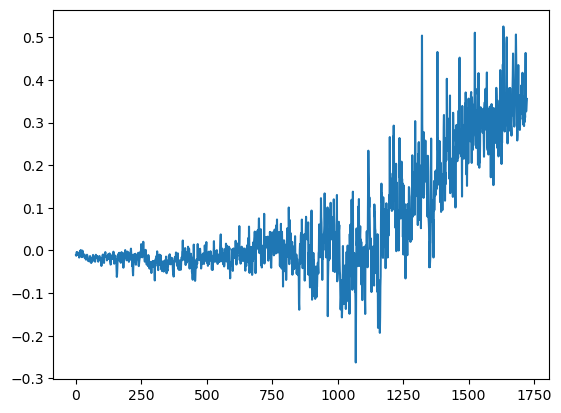

In [62]:
avg_8000 = anomaly_8000.mean().drop(['Latitude', 'Longitude', 'Box_Number',
                                    '9_2023', '10_2023', '11_2023', '12_2023']).values
plt.plot(avg_8000)

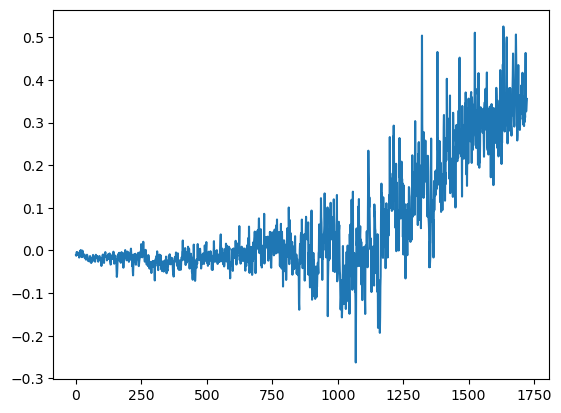

In [63]:
avg_80 = anomaly_80.mean().drop(['9_2023', '10_2023', '11_2023', '12_2023']).values
plt.plot(avg_80)

In [76]:
anomaly_80

,1_1880,2_1880,3_1880,4_1880,5_1880,6_1880,7_1880,8_1880,9_1880,10_1880,...,3_2023,4_2023,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023
0,-0.000067,-0.000116,-0.000032,0.000026,0.000002,0.000002,-0.000002,-0.000033,-0.000005,0.000041,...,1.001333,0.051779,0.519783,0.316774,0.612561,0.415492,0.0,0.0,0.0,0.0
1,-0.113758,-0.279974,-0.053273,0.062316,-0.017265,0.000368,0.025401,-0.025277,-0.021773,0.048866,...,0.693764,0.748640,0.309428,0.236062,0.283365,0.424927,0.0,0.0,0.0,0.0
2,0.020465,0.020128,-0.008299,-0.011543,-0.016534,-0.018552,-0.019865,0.009843,0.008084,-0.052146,...,0.535508,0.910989,1.102170,0.457746,0.573651,0.649107,0.0,0.0,0.0,0.0
3,-0.002429,0.000578,0.001368,-0.000327,0.000105,0.000156,-0.000323,0.000469,-0.002065,-0.001727,...,1.351583,1.012067,0.654682,0.907374,0.344345,0.824795,0.0,0.0,0.0,0.0
4,-0.018205,0.049671,-0.011582,-0.004353,-0.040991,-0.000123,-0.000111,-0.000174,-0.000313,-0.000196,...,0.389274,0.058396,0.221677,0.250437,0.317097,0.247427,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.017649,-0.076914,-0.012597,-0.105402,0.072641,-0.183497,-0.089977,-0.115323,-0.060967,-0.044112,...,0.060803,0.101113,0.111724,0.152482,0.070626,0.043922,0.0,0.0,0.0,0.0
76,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.096451,0.520310,-0.450807,0.175523,-0.306743,-0.372435,0.0,0.0,0.0,0.0
77,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.376764,0.636798,0.089411,0.601855,0.184654,0.333057,0.0,0.0,0.0,0.0
78,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.309429,0.724534,0.315918,0.586955,0.806718,0.523223,0.0,0.0,0.0,0.0
